In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import LabelEncoder

ruta_csv = 'combined_statistics_full_sobregrupos.csv'
df = pd.read_csv(ruta_csv)

X = df.iloc[:, :-1]
y = df.iloc[:, -1]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.model_selection import GridSearchCV

svc_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'sigmoid']
}

svc = SVC()

# GridSearch para SVC
grid_svc = GridSearchCV(
    estimator=svc,
    param_grid=svc_params,
    cv=5,
    scoring='accuracy',
    verbose=1
)

print("Ajustando SVC...")
grid_svc.fit(X_train_scaled, y_train)

print(f"Mejores hiperparámetros SVC: {grid_svc.best_params_}")
print(f"Mejor precisión SVC: {grid_svc.best_score_:.4f}")

Ajustando SVC...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros SVC: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Mejor precisión SVC: 0.9718


C:\Users\hodei\AppData\Local\Temp\ipykernel_14616\281929679.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


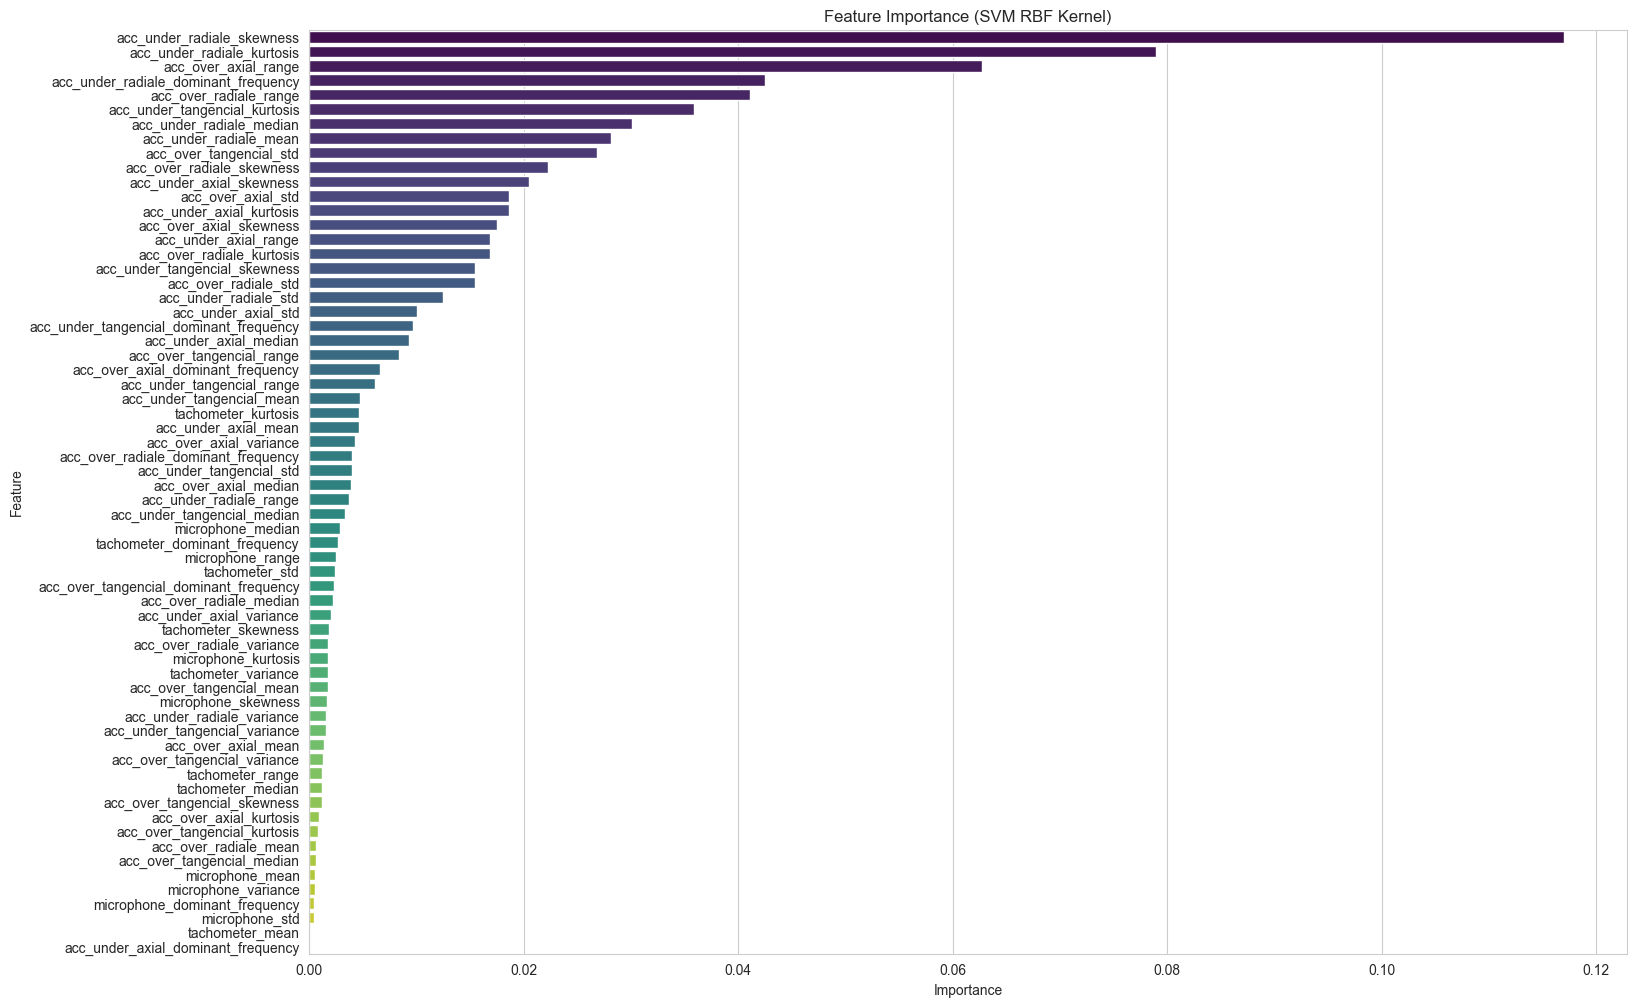

In [3]:
from sklearn.inspection import permutation_importance

svm_basic = SVC(kernel='rbf', probability=True, random_state=42, C=100, gamma=0.01)
svm_basic.fit(X_train_scaled, y_train)

perm_importance = permutation_importance(svm_basic, X_train_scaled, y_train, n_repeats=30, random_state=42)

feature_names = df.iloc[:, :-1].columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': perm_importance.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(17, 12))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance (SVM RBF Kernel)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [4]:
total_importance = importance_df['Importance'].sum()
# print(total_importance) --> efektibamente da 1

cumulative_importance = importance_df['Importance'].cumsum()
selected_features = importance_df[cumulative_importance <= total_importance * 0.9] #cogemos el 90% de la importancia

print("\nSelected Features (90% of importance):")
print(selected_features)


Selected Features (90% of importance):
                                    Feature  Importance
21               acc_under_radiale_skewness    0.117009
22               acc_under_radiale_kurtosis    0.078910
36                     acc_over_axial_range    0.062714
23     acc_under_radiale_dominant_frequency    0.042521
44                   acc_over_radiale_range    0.041047
30            acc_under_tangencial_kurtosis    0.035855
17                 acc_under_radiale_median    0.030107
16                   acc_under_radiale_mean    0.028162
50                  acc_over_tangencial_std    0.026774
45                acc_over_radiale_skewness    0.022286
13                 acc_under_axial_skewness    0.020513
34                       acc_over_axial_std    0.018632
14                 acc_under_axial_kurtosis    0.018611
37                  acc_over_axial_skewness    0.017457
12                    acc_under_axial_range    0.016859
46                acc_over_radiale_kurtosis    0.016816
29      

In [7]:
X = X[selected_features['Feature']]
X_scaled = scaler.fit_transform(X)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


svm_basic.fit(X_train_scaled, y_train)

rf_train_pred = svm_basic.predict(X_train_scaled)
rf_test_pred = svm_basic.predict(X_test_scaled)

print("\nClassification Report (Training):")
print(classification_report(y_train, rf_train_pred))

print("\nClassification Report (Testing):")
print(classification_report(y_test, rf_test_pred))


Classification Report (Training):
                         precision    recall  f1-score   support

horizontal-misalignment       0.96      0.99      0.98       160
              imbalance       1.00      1.00      1.00       258
                 normal       0.97      0.89      0.93        36
               overhang       0.99      1.00      0.99       412
              underhang       1.00      1.00      1.00       452
  vertical-misalignment       1.00      0.98      0.99       242

               accuracy                           0.99      1560
              macro avg       0.99      0.98      0.98      1560
           weighted avg       0.99      0.99      0.99      1560


Classification Report (Testing):
                         precision    recall  f1-score   support

horizontal-misalignment       0.95      1.00      0.97        37
              imbalance       0.99      0.99      0.99        75
                 normal       1.00      0.92      0.96        13
               ov

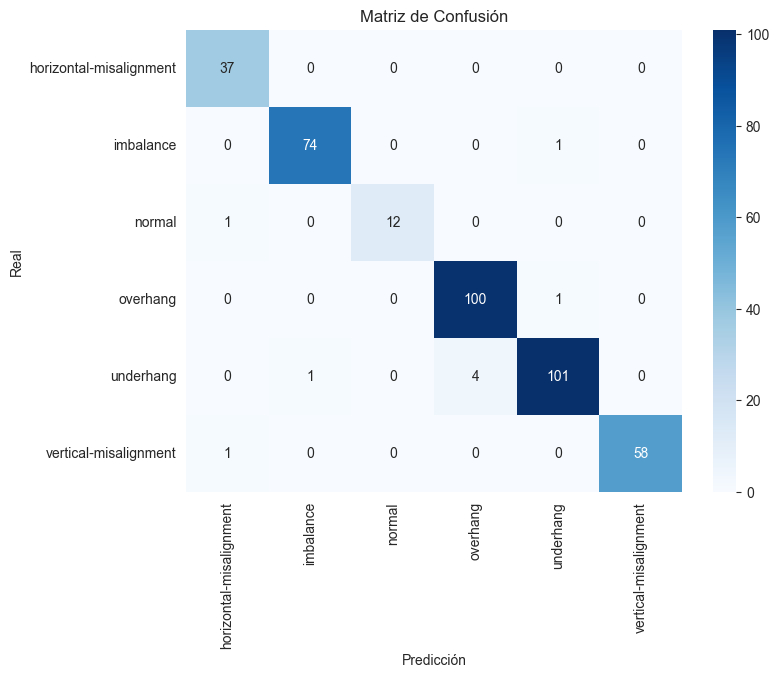

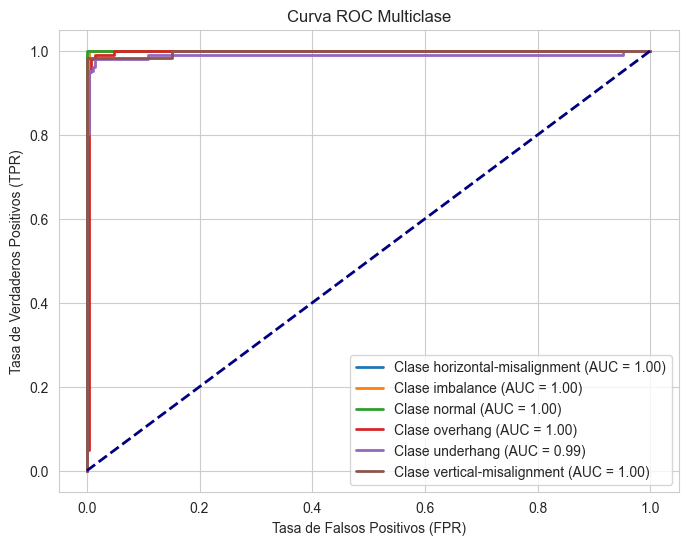

In [8]:
svm_test_pred = svm_basic.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, svm_test_pred)

classes = sorted(set(y_test))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = svm_basic.predict_proba(X_test_scaled)

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()
